In [19]:
from numpy import save, load
from pandas import read_csv
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 

In [20]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
x_train = np.load('gdrive/My Drive/dataset/dataset6/trainX.npy')
y_train = np.load('gdrive/My Drive/dataset/dataset6/trainy.npy')
x_test = np.load('gdrive/My Drive/dataset/dataset6/testX.npy')
y_test = np.load('gdrive/My Drive/dataset/dataset6/testy.npy')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Mounted at /content/drive
Mounted at /content/gdrive
(66542, 128, 12) (66542, 2) (7600, 128, 12) (7600, 2)


In [21]:
x_train = x_train.transpose(0,2,1)
x_test = x_test.transpose(0,2,1)

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.20, random_state=42)


In [22]:
x_train.shape


(53233, 12, 128)

In [23]:
embed_dim = x_train.shape[-1]   # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = x_train.shape[-1]  # Hidden layer size in feed forward network inside transformer

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm
model = keras.Sequential()
model.add(layers.Input(shape= x_train.shape[1:]))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_block_2 (Transf  (None, 12, 128)          297344    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [24]:
history = model.fit(x_train, y_train, epochs=200, verbose=True, validation_data=(x_validation, y_validation), batch_size=128,callbacks=callbacks)


Epoch 1/200
416/416 [==============================] - 9s 19ms/step - loss: 0.6078 - accuracy: 0.6512 - val_loss: 0.5217 - val_accuracy: 0.7417
Epoch 2/200
416/416 [==============================] - 7s 17ms/step - loss: 0.5098 - accuracy: 0.7505 - val_loss: 0.4642 - val_accuracy: 0.7885
Epoch 3/200
416/416 [==============================] - 7s 17ms/step - loss: 0.4631 - accuracy: 0.7825 - val_loss: 0.4254 - val_accuracy: 0.8045
Epoch 4/200
416/416 [==============================] - 7s 17ms/step - loss: 0.4272 - accuracy: 0.8049 - val_loss: 0.3921 - val_accuracy: 0.8203
Epoch 5/200
416/416 [==============================] - 7s 17ms/step - loss: 0.4033 - accuracy: 0.8163 - val_loss: 0.3740 - val_accuracy: 0.8385
Epoch 6/200
416/416 [==============================] - 7s 17ms/step - loss: 0.3819 - accuracy: 0.8290 - val_loss: 0.3454 - val_accuracy: 0.8485
Epoch 7/200
416/416 [==============================] - 7s 17ms/step - loss: 0.3666 - accuracy: 0.8378 - val_loss: 0.3351 - val_accuracy:

In [25]:
loss, accuracy = model.evaluate(x_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9119
Testing Accuracy: 0.8230


>knn -101.019 (7.161)
>cart -147.584 (11.787)
>svm -162.419 (12.565)
>stacking -56.834 (5.159)


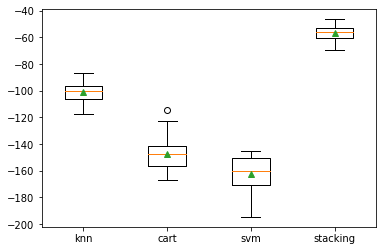

In [26]:

# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [27]:
# evaluate a weighted average ensemble for classification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
 
# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('bayes', GaussianNB()))
	return models
 
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		acc = accuracy_score(y_val, yhat)
		# store the performance
		scores.append(acc)
		# report model performance
	return scores
 
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.50, random_state=1)
# split the full train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train, X_val, y_train, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train_full, y_train_full)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Weighted Avg Accuracy: %.3f' % (score*100))



[0.8896969696969697, 0.8642424242424243, 0.8812121212121212]
Weighted Avg Accuracy: 90.520
